In [2]:
%run /home/user/besos/Matthias/tools/imports.ipynb
from tensorflow.keras import regularizers
def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(2)]
        X = standardization[0].fit_transform(X)
        y = standardization[1].fit_transform(y)
    else:
        X = standardization[0].transform(X)
        y = standardization[1].transform(y)

    return X, y, standardization

def get_model_3(n_params=22, alpha=0.001, n_neurons=256):
    inputs = Input(shape=(n_params))
    hidden = Dense(n_neurons, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(inputs)
    outputs = Dense(1, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(hidden)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='mse')
    model.summary()
    
    return model

ann = KerasRegressor(build_fn=get_model_3, epochs=800)

In [3]:
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
X_train, X_test, y_train,  y_test = train_test_split(X.iloc[:,:24].drop('weather_file',axis=1).drop('HDD18',axis=1), y, test_size=0.2, shuffle=True)
X_train, y_train, standardization = preprocess(X_train, y_train)
X_test, y_test, _ = preprocess(X_test, y_test, standardization)
estimator = copy.deepcopy(ann)

early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
history = estimator.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               5888      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


W0815 23:33:36.281492 140133566437184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 6400 samples, validate on 1600 samples
Epoch 1/800
6400/6400 [==============================] - 0s 64us/sample - loss: 0.1792 - val_loss: 0.0874
Epoch 2/800
6400/6400 [==============================] - 0s 43us/sample - loss: 0.0739 - val_loss: 0.0694
Epoch 3/800
6400/6400 [==============================] - 0s 43us/sample - loss: 0.0584 - val_loss: 0.0549
Epoch 4/800
6400/6400 [==============================] - 0s 44us/sample - loss: 0.0470 - val_loss: 0.0459
Epoch 5/800
6400/6400 [==============================] - 0s 43us/sample - loss: 0.0407 - val_loss: 0.0415
Epoch 6/800
6400/6400 [==============================] - 0s 42us/sample - loss: 0.0366 - val_loss: 0.0365
Epoch 7/800
6400/6400 [==============================] - 0s 42us/sample - loss: 0.0332 - val_loss: 0.0367
Epoch 8/800
6400/6400 [==============================] - 0s 43us/sample - loss: 0.0307 - val_loss: 0.0319
Epoch 9/800
6400/6400 [==============================] - 0s 45us/sample - loss: 0.0291 - val_loss: 0.031

Winnipeg        R2 score:    98.44 %, MAPE:   3.63 %, RMSPE:  5.82 %.
Ottawa          R2 score:    97.45 %, MAPE:   4.06 %, RMSPE:  5.36 %.
Longueuil       R2 score:    97.91 %, MAPE:   4.16 %, RMSPE:  6.03 %.
Toronto         R2 score:    92.97 %, MAPE:   6.76 %, RMSPE:  8.54 %.
Taloyoak        R2 score:    95.90 %, MAPE:   4.72 %, RMSPE:  6.75 %.
Lesage          R2 score:    98.18 %, MAPE:   3.66 %, RMSPE:  5.29 %.
Montreal        R2 score:    98.16 %, MAPE:   3.71 %, RMSPE:  4.92 %.
Norman_Wells    R2 score:    98.66 %, MAPE:   2.86 %, RMSPE:  4.18 %.
Edmonton        R2 score:    98.51 %, MAPE:   3.93 %, RMSPE:  6.64 %.
Victoria        R2 score:    49.83 %, MAPE:  29.58 %, RMSPE: 58.97 %.
Hamilton        R2 score:    96.96 %, MAPE:   5.24 %, RMSPE:  8.78 %.
Halifax         R2 score:    93.09 %, MAPE:   9.47 %, RMSPE: 13.25 %.
London          R2 score:    95.58 %, MAPE:   4.93 %, RMSPE:  6.13 %.
Laval           R2 score:    98.23 %, MAPE:   3.74 %, RMSPE:  5.45 %.
Calgary         R2 s

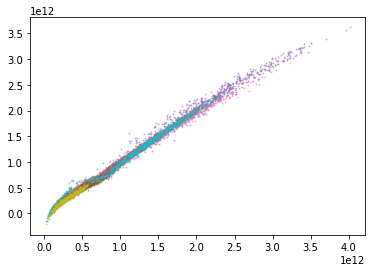

In [5]:
%run /home/user/besos/Matthias/tools/imports.ipynb
scores = np.ndarray((20,3))
for i, city in enumerate(CAN_cities.keys()):
    X_test, y_test = read_samples(region=city, param_set=23, output_meter = 'DistrictHeating:Facility')
    X_test, y_test, _ = preprocess(X_test.iloc[:,:24].drop('weather_file',axis=1).drop('HDD18',axis=1), y_test, standardization)
    y_pred_test = estimator.predict(X_test)
    y_true = standardization[1].inverse_transform(y_test.reshape(len(X_test)))
    y_pred = standardization[1].inverse_transform(y_pred_test.reshape(len(X_test)))
    scores[i, 0] = r2_score(y_true, y_pred) * 100
    scores[i, 1] = MAPE(y_true, y_pred)
    scores[i, 2] = RMSPE(y_true, y_pred)
    plt.scatter(y_true, y_pred, s=1, alpha=0.4)
    print(f'{city:15s} R2 score: {scores[i, 0]:8.2f} %, MAPE: {scores[i, 1]:6.2f} %, RMSPE: {scores[i, 2]:5.2f} %.')

print(f'{"Mean":15s} R2 score: {np.mean(scores[:,0]):8.2f} %, MAPE: {np.mean(scores[:,1]):6.2f} %, RMSPE: {np.mean(scores[:,2]):5.2f} %.')

In [6]:
np.save('model3_scores_test_loc', scores)